In [1]:
# import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = (12, 8)

In [2]:
# data parameters
n_monto_carlo = 10 ** 5
risky_asset = ['TSLA', 'AAPL', 'GOOG', 'MSFT', 'NVDA', 'AMZN', 'META']
start_date = '2018-01-01'
end_date = '2024-01-01'

n_assets = len(risky_asset)
n_assets

7

In [3]:
# download the data
prices_df = pd.read_csv("rolling_forecast_predictions.csv")
prices_df.set_index('Date', inplace=True)
print(f'read {prices_df.shape[0]} rows of data.')
N_DAYS = prices_df.shape[0]
prices_df.head(3)

read 423 rows of data.


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2022-09-21,0.003714,0.004706,0.006044,0.005927,0.006055,0.006907,0.001263
2022-09-22,-0.005646,-0.000084,-0.000700,0.001051,0.000791,-0.001780,0.001952
2022-09-23,0.007563,0.000970,0.004268,0.002826,0.003903,0.010815,0.000705


In [4]:
# show the percentage returns
returns_df = prices_df
returns_df.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2022-09-21,0.003714,0.004706,0.006044,0.005927,0.006055,0.006907,0.001263
2022-09-22,-0.005646,-0.000084,-0.000700,0.001051,0.000791,-0.001780,0.001952
2022-09-23,0.007563,0.000970,0.004268,0.002826,0.003903,0.010815,0.000705
2022-09-26,0.000082,0.002890,0.001410,0.005057,0.001538,-0.002103,0.000033
2022-09-27,0.003129,-0.000035,0.002861,0.003239,0.003434,0.002973,-0.000406


In [5]:
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS
avg_returns, cov_mat

(AAPL     0.539330
 AMZN     0.387059
 GOOGL    0.316948
 META     0.149963
 MSFT     0.479155
 NVDA     0.940926
 TSLA     0.881646
 dtype: float64,
            AAPL      AMZN     GOOGL      META      MSFT      NVDA      TSLA
 AAPL   0.002828  0.000233  0.001419  0.001114  0.002264  0.002371 -0.000065
 AMZN   0.000233  0.000469  0.000273  0.000560  0.000488  0.000380  0.000084
 GOOGL  0.001419  0.000273  0.002722  0.001293  0.002130  0.001537  0.000035
 META   0.001114  0.000560  0.001293  0.003585  0.001870  0.000939  0.000119
 MSFT   0.002264  0.000488  0.002130  0.001870  0.005951  0.003552  0.000165
 NVDA   0.002371  0.000380  0.001537  0.000939  0.003552  0.008219  0.000689
 TSLA  -0.000065  0.000084  0.000035  0.000119  0.000165  0.000689  0.003378)

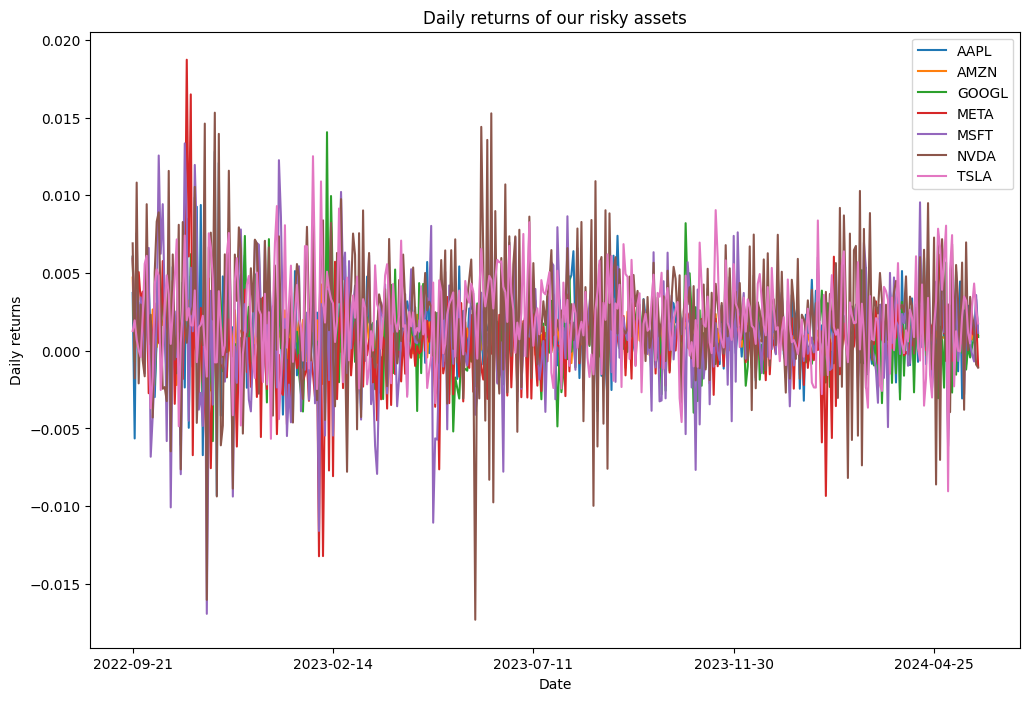

In [6]:
returns_df.plot(title='Daily returns of our risky assets')
plt.ylabel('Daily returns')
plt.show()

In [7]:
np.random.seed(666)
weights = np.random.random(size=(n_monto_carlo, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [8]:
portf_rtns = weights @ avg_returns

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(weights[i] @ cov_mat @ weights[i].T))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

In [9]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio': portf_sharpe_ratio})

In [10]:
n_internal = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), n_internal)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for index in range(n_internal):
    if portf_rtns_ef[index] not in portf_rtns:
        indices_to_skip.append(index)
        continue
    matched_index = np.where(portf_rtns == portf_rtns_ef[index])
    portf_vol_ef.append(np.min(portf_vol[matched_index]))


# delete the inner dot
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

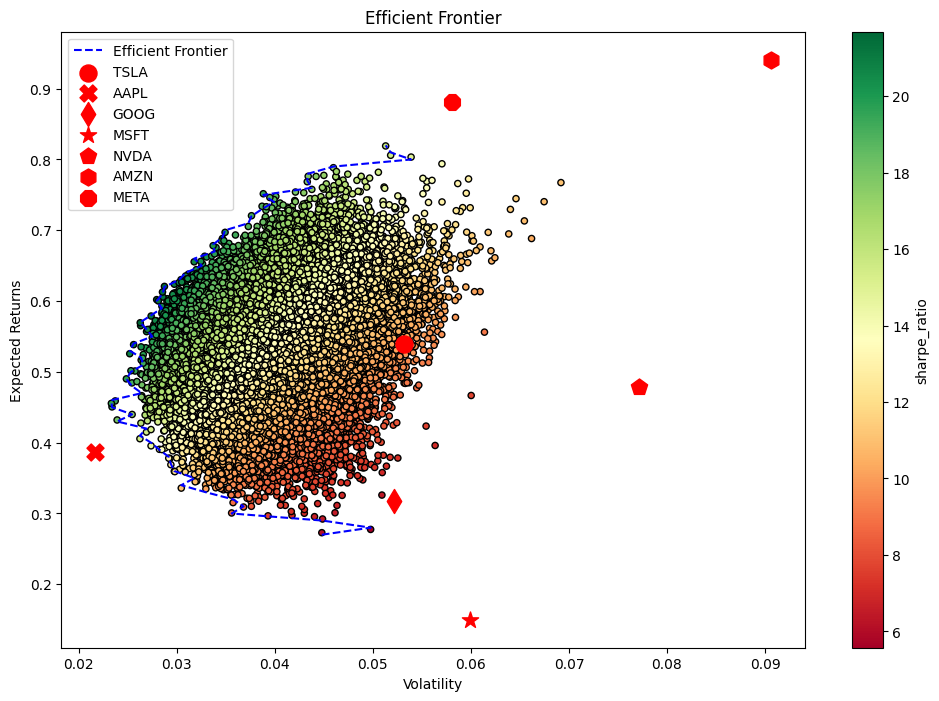

In [11]:
MARKS = ['o', 'X', 'd', '*', 'p', 'h', '8']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

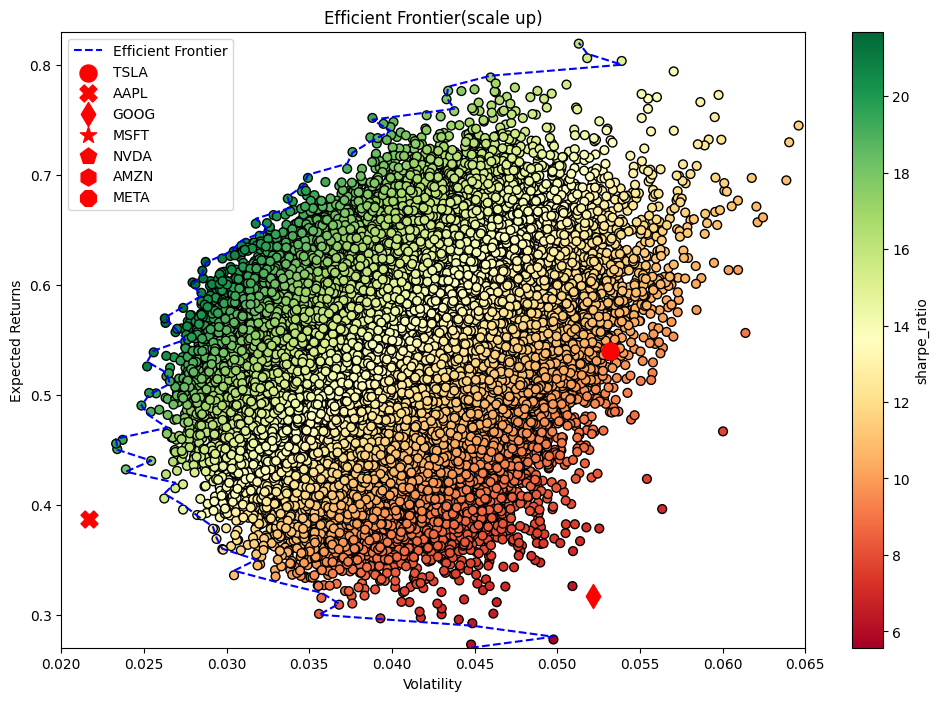

In [12]:
# a bigger figure
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',\
                      cmap='RdYlGn', edgecolors='black', ax=ax, s = 40)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier(scale up)',\
       xlim = (0.02, 0.065), ylim = (0.27, 0.83))
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--', label='Efficient Frontier')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='red',
                label=risky_asset[asset_index])
ax.legend()
plt.show()

In [13]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [14]:
print('Maximum Sharpe Ratio portfolio --->')
print('Performance:')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio --->
Performance:
returns: 56.94% volatility: 2.63% sharpe_ratio: 2168.09% 
Weights:
TSLA: 20.33% AAPL: 38.06% GOOG: 5.42% MSFT: 2.81% NVDA: 0.88% AMZN: 0.50% META: 32.01% 

In [15]:
print('Minimum Volatility portfolio --->')
print('Performance:')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights:')
for x, y in zip(risky_asset, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio --->
Performance:
returns: 45.55% volatility: 2.33% sharpe_ratio: 1953.43% 
Weights:
TSLA: 12.66% AAPL: 55.75% GOOG: 2.72% MSFT: 12.42% NVDA: 0.49% AMZN: 1.87% META: 14.10% 

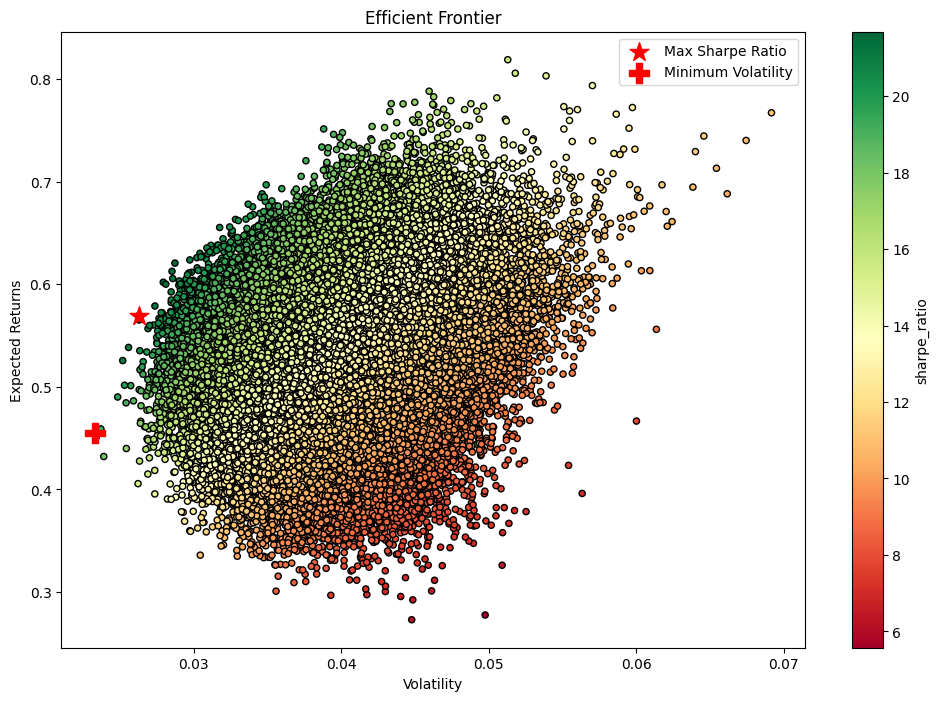

In [16]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, y=max_sharpe_portf.returns, 
           c='red', marker='*', s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, y=min_vol_portf.returns, 
           c='red', marker='P', s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.legend()
plt.show()